In [1]:
import numpy as np
import pandas as pd

In [2]:
train_path = "X_train.csv"
label_path = "y_train.csv"
test_path = "X_test.csv"
samples_path = "samples.csv"

df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
labeldf = pd.read_csv(label_path)


labels = labeldf.values
data = df.values
test_data = test_df.values

data = data[:,1:]
test_data = test_data[:,1:]
labels = labels[:,1]


print(data.shape)
print(test_data.shape)
print(labels.shape)

(5117, 17813)
(3411, 17813)
(5117,)


In [10]:
label_path = "y_train.csv"
labeldf = pd.read_csv(label_path)
labels = labeldf.values
labels = labels[:,1]

In [3]:
def count_instances(labels):
    unique, counts = np.unique(labels,return_counts=True)
    return dict(zip(unique,counts))

class_counts = count_instances(labels)

print("Class 0 Counts: {}".format(class_counts[0]))
print("Class 1 Counts: {}".format(class_counts[1]))
print("Class 2 Counts: {}".format(class_counts[2]))
print("Class 3 Counts: {}".format(class_counts[3]))


(num_train, max_timesteps) = data.shape
(num_test, _) = test_data.shape

Class 0 Counts: 3030
Class 1 Counts: 443
Class 2 Counts: 1474
Class 3 Counts: 170


In [31]:
# discard nan
for i in range(data.shape[0]):
    data[i] = data[i][np.logical_not(np.isnan(data[i]))]

for i in range(test_data.shape[0]):
    test_data[i] = test_data[i][np.logical_not(np.isnan(test_data[i]))]


ValueError: could not broadcast input array from shape (16856) into shape (17813)

In [30]:
# NORMALIZE DATA
from sklearn.preprocessing import Normalizer
data_norm_discardnan = Normalizer().fit_transform(data[np.logical_not(np.isnan(data))])
test_data_norm_discardnan = Normalizer().fit_transform(test_data[np.logical_not(np.isnan(test_data))])


ValueError: Expected 2D array, got 1D array instead:
array=[215. 210. 200. ... -50. -54. -59.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [2]:
# dk why I did this, might end up useful
def min_len(data):
    # faster to search column wise
    wherenan = np.isnan(data)
    for j in range(data.shape[1]):
        if np.any(wherenan[:,j]):
            return j
    """
    min_len = data.shape[1]
    for i in range(data.shape[0]):
        cond = np.isnan(data[i,:])
        if np.any(cond):
            nan_index = np.where(cond)[0][0]
            if nan_index < min_len:
                min_len = nan_index
            
    return min_len
    """
    
def fill_periodic(data):
    nanplaces = np.isnan(data)
    num_col = data.shape[1]
    for i in range(data.shape[0]):
        stop_index = np.argmax(nanplaces[i,:]==True)-1
        data[i,:] = np.resize(data[i,:stop_index],num_col)
    return data

def fill_zero(data):
    return np.nan_to_num(data)

def fft_zero_pad(data):
    zero_padded = np.nan_to_num(data)
    return np.fft.fft(zero_padded, axis=0)

# implementing below link
# https://dsp.stackexchange.com/questions/25435/dft-for-audio-classification-signals-of-different-lengths
def fft_mod_min(data):
    l = min_len(data)
    # a divisor of the column number
    split_size = data.shape[1]/379
    zero_padded = np.nan_to_num(data)
    splits = np.split(zero_padded,split_size, axis = 1)
    splits = np.array(splits)
    # caution: not sure if the order of rows gets messed up here
    # so that the labels correspond to the correct order
    splits = splits.transpose(1,0,2)
    sums = np.sum(splits, axis = 1)
    
    return np.fft.fft(sums,axis=0)

#mod_min_fft_train = fft_mod_min(data)
#zero_pad_fft_train = fft_zero_pad(data)

#mod_min_fft_test = fft_mod_min(test_data)
#zero_pad_fft_test = fft_zero_pad(test_data)

#print("Mod_min FFt shape {}".format(mod_min_fft_train.shape))
#print("Zero Padded FFt shape {}".format(zero_pad_fft_train.shape))

In [3]:
from biosppy.signals.ecg import ecg


def extract_heart(data):
    All_ts = []
    All_filtered = []
    All_rpeaks = []
    All_templates_ts = []
    All_templates = []
    All_heart_rate_ts = []
    All_heart_rate = []
    thrown_away = []
    nanplaces = np.isnan(data)
    for i in range(data.shape[0]):
        stop_index = np.argmax(nanplaces[i,:]==True) -1
        try:
            ts, filtered, rpeaks, templates_ts,templates, heart_rate_ts, heart_rate = ecg(data[i,:stop_index], sampling_rate=300,show= False)
        except:
            print("Index {} was bad".format(i))
            thrown_away.append(i)
        """
        print(ts.shape)
        print(filtered.shape)
        print(rpeaks.shape)
        print(templates_ts.shape)
        print(templates.shape)
        print(heart_rate_ts.shape)
        print(heart_rate.shape)
        """
        All_ts.append(ts)
        All_filtered.append(filtered)
        All_rpeaks.append(rpeaks)
        All_templates_ts.append(templates_ts)
        All_templates.append(templates)
        All_heart_rate_ts.append(heart_rate_ts)
        All_heart_rate.append(heart_rate)
        
    return All_ts, All_filtered, All_rpeaks, All_templates_ts, All_templates, All_heart_rate_ts, All_heart_rate, thrown_away
        

ts, filtered, rpeaks, templates_ts,templates, heart_rate_ts, heart_rate, thrown_away= extract_heart(data)


NameError: name 'data' is not defined

In [13]:
def make_numpy(heart_thing):
    
    heart_np = np.zeros((len(heart_thing),max_timesteps))
    for i in range(heart_np.shape[0]):
        nans = np.empty((1,max_timesteps-len(heart_thing[i])))
        nans[:] = np.nan
        vals = np.array(heart_thing[i]).reshape(1,len(heart_thing[i]))
        heart_np[i,:] = vals#np.concatenate((vals,nans),axis=1)
    return heart_np
"""
ts = make_numpy(ts)
filtered = make_numpy(filtered)
rpeaks = make_numpy(rpeaks)
templates_ts = make_numpy(templates_ts)
templates = make_numpy(templates)
heart_rate_ts = make_numpy(heart_rate_ts)
heart_rate = make_numpy(heart_rate)
"""



'\nts = make_numpy(ts)\nfiltered = make_numpy(filtered)\nrpeaks = make_numpy(rpeaks)\ntemplates_ts = make_numpy(templates_ts)\ntemplates = make_numpy(templates)\nheart_rate_ts = make_numpy(heart_rate_ts)\nheart_rate = make_numpy(heart_rate)\n'

[30]
[4]
[3]
[0]


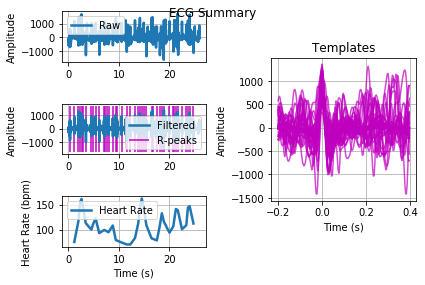

In [14]:
#ts, filtered, rpeaks, templates_ts,templates, heart_rate_ts, heart_rate

from biosppy.plotting import plot_ecg


nanplaces = np.isnan(data)
y_0 = np.argwhere(labels==0)
y_1 = np.argwhere(labels==1)
y_2 = np.argwhere(labels==2)
y_3 = np.argwhere(labels==3)


ind3 = y_3[0]
ind2 = y_2[0]
ind1 = y_1[0]
ind = y_0[0]
print(ind3)
print(ind2)
print(ind1)
print(ind)
stop_index = np.argmax(nanplaces[30,:]==True) -1


ts3, filtered3, rpeaks3, templates_ts3,templates3, heart_rate_ts3, heart_rate3 = ecg(data[30,:stop_index], sampling_rate=300,show= True)




In [ ]:
stop_index = np.argmax(nanplaces[4,:]==True) -1


ts2, filtered2, rpeaks2, templates_ts2,templates2, heart_rate_ts2, heart_rate2 = ecg(data[4,:stop_index], sampling_rate=300,show= True)



In [ ]:
stop_index = np.argmax(nanplaces[3:]==True) -1


ts1, filtered1, rpeaks1, templates_ts1,templates1, heart_rate_ts1, heart_rate1 = ecg(data[3,:stop_index], sampling_rate=300,show= True)

print(ts1.shape)
print(filtered1.shape)
print(rpeaks1.shape)
print(templates_ts1.shape)
print(templates1.shape)
print(heart_rate_ts1.shape)
print(heart_rate1.shape)



In [ ]:
stop_index = np.argmax(nanplaces[0,:]==True) -1


ts0, filtered0, rpeaks0, templates_ts0,templates0, heart_rate_ts0, heart_rate0 = ecg(data[0,:stop_index], sampling_rate=300,show= True)

print(ts0.shape)
print(filtered0.shape)
print(rpeaks0)
print(templates_ts0.shape)
print(templates0.shape)
print(heart_rate_ts0.shape)
print(heart_rate0.shape)


In [ ]:
import math
def min_len(data):
    # faster to search column wise
    wherenan = np.isnan(data)
    for j in range(data.shape[1]):
        if np.any(wherenan[:,j]):
            return j
        
min_len(data)
def pad_periodic(data):
    nanplaces = np.isnan(data)
    for i in range(data.shape[0]):
        stop_index = np.argmax(nanplaces[i,:]==True) -1
        if stop_index > 0:
            rpts = math.floor(data.shape[0]/stop_index)
            print(rpts)
            data[i,:] = np.tile(data[i,:],rpts)
            #print(fill.shape)
        
        
pad_periodic(data)

In [20]:
#ts, filtered, rpeaks, templates_ts,templates, heart_rate_ts, heart_rate
#what to fucking do with this shit????


In [ ]:
import math


x_folds, y_folds = make_folds(5, sxx, labels)
for i, y in enumerate(y_folds):
    print(y_folds[i].shape)
    print("Number of instances in fold {}".format(i))
    class_counts = count_instances(y_folds[i])
    print("Class 0 Counts: {}".format(class_counts[0]))
    print("Class 1 Counts: {}".format(class_counts[1]))
    print("Class 2 Counts: {}".format(class_counts[2]))
    print("Class 3 Counts: {}".format(class_counts[3]))





In [ ]:
x = np.zeros( (106, 106, 3) )
result = x[0,:, :, ]

In [5]:
def find_centerwave(templates):
    n_short = len(templates)
    dist_mat = np.zeros([n_short, n_short])
    for i in range(n_short):
        dist_mat[i, i] = 0.0
        for j in range(i+1, n_short):
            tmp_dist = dist(templates[i], templates[j])
            dist_mat[i, j] = tmp_dist
            dist_mat[j, i] = tmp_dist

    dist_mat_dist = np.sum(dist_mat, axis=1)
    centerwave = templates[np.argsort(dist_mat_dist)[0]]
    return centerwave

def dist(ts1, ts2):
    '''
    Input: two vectors
    Output: distance, numeric
    '''
    dist_num = np.linalg.norm(np.array(ts1) - np.array(ts2))
    return dist_num

def fftanalysis(signal, rate=300, first=8):
    try:
        fftsignal = np.abs(np.fft.fft(signal))**2
        if len(fftsignal < 8):
            fftsignal = np.append(fftsignal, np.zeros(first - len(fftsignal)))
    except Exception:
        fftsignal = np.zeros(first)
    # print(fftsignal)
    # freqs = np.fft.fftfreq(len(signal), d=1 / rate)
    # print(freqs)
    # plt.bar(freqs[:first], fftsignal[:first])
    # plt.show()
    return fftsignal[:first]



In [6]:

##################################################
### tools
##################################################
def zigzag(ts):
    '''
    number of zigzag
    '''
    num_zigzag = 1
    for i in range(len(ts)-2):
        num_1 = ts[i]
        num_2 = ts[i+1]
        num_3 = ts[i+2]
        if (num_2 - num_1) * (num_3 - num_2) < 0:
            num_zigzag += 1
    return num_zigzag

def dist(ts1, ts2):
    '''
    Input: two vectors
    Output: distance, numeric
    '''
    dist_num = np.linalg.norm(np.array(ts1) - np.array(ts2))
    return dist_num

def resample_unequal(ts, length):
    '''
    TODO: 
        1. average of several points
    '''
    resampled = [0.0] * length
    resampled_idx = list(np.linspace(0.0, len(ts)-1, length))
    for i in range(length):
        idx_i = resampled_idx[i]
        low_idx = int(np.floor(idx_i))
        low_weight = abs(idx_i - np.ceil(idx_i))
        high_idx = int(np.ceil(idx_i))
        high_weight = abs(idx_i - np.floor(idx_i))
        resampled[i] = low_weight * ts[low_idx] + high_weight * ts[high_idx]
#        print(idx_i, resampled[i], low_weight, high_weight)
#        break
    return resampled

def LongThresCrossing(ts, thres):
    cnt = 0
    pair_flag = 1
    pre_loc = 0
    width = []
    for i in range(len(ts)-1):
        if (ts[i] - thres) * (ts[i+1] - thres) < 0:
            cnt += 1
            if pair_flag == 1:
                width.append(i-pre_loc)
                pair_flag = 0
            else:
                pair_flag = 1
                pre_loc = i
        if ts[i] == thres and (ts[i-1] - thres) * (ts[i+1] - thres) < 0:
            cnt += 1
    
    if len(width) > 1:
        return [cnt, np.mean(width)]
    else:
        return [cnt, 0.0]

def autocorr(ts, t):
    return np.corrcoef(np.array([ts[0:len(ts)-t], ts[t:len(ts)]]))[0,1]


##################################################
### get features
##################################################
def centerwave_simp(ts):
    '''
    ### 1
    resample centerwave to length 200, as features directly
    '''
    length = 200
    resampled_center_wave_raw = resample_unequal(ts, length)
    return resampled_center_wave_raw

def centerwave_zero_crossing(ts):
    '''
    ### 2
    '''

    cnt = 0
    for i in range(len(ts)-1):
        if ts[i] * ts[i+1] < 0:
            cnt += 1
        if ts[i] == 0 and ts[i-1] * ts[i+1] < 0:
            cnt += 1
    return [cnt]

def centerwave_basic_stat(ts):
    '''
    ### 3
    stat feat
    '''

    
    length = len(ts)
    area = np.sum(np.abs(ts))
    
    Max = max(ts)
    Min = min(ts)
    Range = max(ts) - min(ts)
    Var = np.var(ts)
    Skew = stats.skew(ts)
    Kurtosis = stats.kurtosis(ts)
    Median = np.median(ts)

    p_1 = np.percentile(ts, 1)
    p_5 = np.percentile(ts, 5)
    p_10 = np.percentile(ts, 10)
    p_25 = np.percentile(ts, 25)
    p_75 = np.percentile(ts, 75)
    p_90 = np.percentile(ts, 90)
    p_95 = np.percentile(ts, 95)
    p_99 = np.percentile(ts, 99)

    range_99_1 = p_99 - p_1
    range_95_5 = p_95 - p_5
    range_90_10 = p_90 - p_10
    range_75_25 = p_75 - p_25

    
    return [length, area, 
            Max, Min, Range, Var, Skew, Kurtosis, Median, 
            p_1, p_5, p_95, p_99, 
            p_10, p_25, p_75, p_90, 
            range_99_1, range_95_5, range_90_10, range_75_25]

def centerwave_wave_feature(ts):
    '''
    ### 4
    Electrocardiogram Feature Extraction and Pattern Recognition Using a Novel Windowing Algorithm
        
    TODO: more on how to detect PT waves
    '''

    feat = []


    ### key points
    T_start = round(0.15 * len(ts))
    T_end = round(0.55 * len(ts))
    P_start = round(0.65 * len(ts))
    P_end = round(0.95 * len(ts))
    
    T_wave = ts[T_start:T_end]
    P_wave = ts[P_start:P_end]
    
    T_peak = max(T_wave)
    P_peak = max(P_wave)
    Q_peak = min(ts[-6:])
    R_peak = ts[0]
    S_peak = min(ts[:6])
    
    T_loc = np.argmax(T_wave)
    P_loc = np.argmax(P_wave)
    Q_loc = -np.argmin(ts[-6:]) - len(ts)
    R_loc = 0
    S_loc = np.argmin(ts[:6])
                    
    
    ### features (5)
    PR_interval = P_loc - 0
    QRS_duration = S_loc - Q_loc
    QT_interval = T_loc - Q_loc
    QT_corrected = QT_interval / len(ts)
    if QRS_duration == 0:
        vent_rate = 0
    else:
        vent_rate = 1 / QRS_duration
    
    ### number of f waves (2)
    TQ_interval = ts[T_loc:Q_loc]
    thres = np.mean(TQ_interval) + (T_peak - np.mean(TQ_interval))/50
    NF, Fwidth = LongThresCrossing(TQ_interval, thres)
        
    ### more features (16)
    RQ_amp = R_peak - Q_peak
    RS_amp = R_peak - S_peak
    ST_amp = T_peak - S_peak
    PQ_amp = P_peak - Q_peak
    QS_amp = Q_peak - S_peak
    RP_amp = R_peak - P_peak
    RT_amp = R_peak - T_peak
    
    ST_interval = T_loc - S_loc
    RS_interval = S_loc - R_loc
    
    T_peak = T_peak
    P_peak = P_peak
    Q_peak = Q_peak
    R_peak = R_peak
    S_peak = S_peak
    
    if RS_interval == 0:
        RS_slope = 0
    else:
        RS_slope = RS_amp / RS_interval                
    if ST_interval == 0:
        ST_slope = 0
    else:
        ST_slope = ST_amp / ST_interval
    
    
    ### 
    feat.append(PR_interval)
    feat.append(QRS_duration)
    feat.append(QT_interval)
    feat.append(QT_corrected)
    feat.append(vent_rate)
    
    feat.append(NF)
    feat.append(Fwidth)

    feat.append(RQ_amp)
    feat.append(RS_amp)
    feat.append(ST_amp)
    feat.append(PQ_amp)
    feat.append(QS_amp)
    feat.append(RP_amp)
    feat.append(RT_amp)
    feat.append(ST_interval)
    feat.append(RS_interval)
    feat.append(T_peak)
    feat.append(P_peak)
    feat.append(Q_peak)
    feat.append(R_peak)
    feat.append(S_peak)
    feat.append(RS_slope)
    feat.append(ST_slope)
    
    return feat

def centerwave_autocorr(ts):
    '''
    ### 5
    auto-coefficient, with lag
    '''
    feat = []
    num_lag = 12
    
    
    for i in range(num_lag):
        feat.append(autocorr(ts, i))

    return feat

def centerwave_zigzag(ts):
    '''
    ### 6
    number of zigzag in centerwave
    '''
    num_zigzag = zigzag(ts)
    return [num_zigzag]
        

In [7]:
  def centerwave_wave_feature(ts):
    '''
    ### 4
    Electrocardiogram Feature Extraction and Pattern Recognition Using a Novel Windowing Algorithm
        
    TODO: more on how to detect PT waves
    '''

    feat = []


    ### key points
    T_start = round(0.15 * len(ts))
    T_end = round(0.55 * len(ts))
    P_start = round(0.65 * len(ts))
    P_end = round(0.95 * len(ts))
    
    T_wave = ts[T_start:T_end]
    P_wave = ts[P_start:P_end]
    
    T_peak = max(T_wave)
    P_peak = max(P_wave)
    Q_peak = min(ts[-6:])
    R_peak = ts[0]
    S_peak = min(ts[:6])
    
    T_loc = np.argmax(T_wave)
    P_loc = np.argmax(P_wave)
    Q_loc = -np.argmin(ts[-6:]) - len(ts)
    R_loc = 0
    S_loc = np.argmin(ts[:6])
                    
    
    ### features (5)
    PR_interval = P_loc - 0
    QRS_duration = S_loc - Q_loc
    QT_interval = T_loc - Q_loc
    QT_corrected = QT_interval / len(ts)
    if QRS_duration == 0:
        vent_rate = 0
    else:
        vent_rate = 1 / QRS_duration
    
    ### number of f waves (2)
    TQ_interval = ts[T_loc:Q_loc]
    thres = np.mean(TQ_interval) + (T_peak - np.mean(TQ_interval))/50
    NF, Fwidth = LongThresCrossing(TQ_interval, thres)
        
    ### more features (16)
    RQ_amp = R_peak - Q_peak
    RS_amp = R_peak - S_peak
    ST_amp = T_peak - S_peak
    PQ_amp = P_peak - Q_peak
    QS_amp = Q_peak - S_peak
    RP_amp = R_peak - P_peak
    RT_amp = R_peak - T_peak
    
    ST_interval = T_loc - S_loc
    RS_interval = S_loc - R_loc
    
    T_peak = T_peak
    P_peak = P_peak
    Q_peak = Q_peak
    R_peak = R_peak
    S_peak = S_peak
    
    if RS_interval == 0:
        RS_slope = 0
    else:
        RS_slope = RS_amp / RS_interval                
    if ST_interval == 0:
        ST_slope = 0
    else:
        ST_slope = ST_amp / ST_interval
    
    
    ### 
    feat.append(PR_interval)
    feat.append(QRS_duration)
    feat.append(QT_interval)
    feat.append(QT_corrected)
    feat.append(vent_rate)
    
    feat.append(NF)
    feat.append(Fwidth)

    feat.append(RQ_amp)
    feat.append(RS_amp)
    feat.append(ST_amp)
    feat.append(PQ_amp)
    feat.append(QS_amp)
    feat.append(RP_amp)
    feat.append(RT_amp)
    feat.append(ST_interval)
    feat.append(RS_interval)
    feat.append(T_peak)
    feat.append(P_peak)
    feat.append(Q_peak)
    feat.append(R_peak)
    feat.append(S_peak)
    feat.append(RS_slope)
    feat.append(ST_slope)
    
    return feat

In [16]:
import sys
from biosppy.signals import tools as st
from biosppy.signals.ecg import correct_rpeaks, extract_heartbeats, hamilton_segmenter, ecg
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import argrelmax
from scipy.stats import stats

from scipy.stats import stats
from sklearn.metrics import f1_score
from biosppy import plotting, utils
          
    
def process_data(data, sampling_rate=300, show=False, verbose=True):
    x = []
    nanplaces = np.isnan(data)
    for i, signal in enumerate(data):
        stop_index = np.argmax(nanplaces[i,:]==True)-1
        temp = ecg(signal=signal[:stop_index],
                      sampling_rate=sampling_rate,
                      show=show
                      #segmenter=qrs_detector
                      )
        args = (data[i], temp["ts"], temp["filtered"], temp["rpeaks"],
                temp["templates_ts"], temp["templates"], temp["heart_rate_ts"],
                temp["heart_rate"])
        names = ('original', 'ts', 'filtered', 'rpeaks', 'templates_ts',
                 'templates', 'heart_rate_ts', 'heart_rate')
        temp = utils.ReturnTuple(args, names)
        x.append(temp)
        
        if verbose:
            if i % 300 == 0:
                print("Analysing sample ", i, "...Please wait...")
                sys.stdout.flush()
                
    return x

def signal_stats(signal):
    try:
        # mean, median, max, min, std, skewness, kurtosis
        # check inputs
        if signal is None:
            raise TypeError("Please specify an input signal.")

        # ensure numpy
        signal = np.array(signal)

        # mean
        mean = np.mean(signal)

        # median
        median = np.median(signal)

        # maximum amplitude abs
        maxAmpAbs = np.abs(signal - mean).max()

        # minimum amplitude abs
        minAmpAbs = np.abs(signal - mean).min()

        # maximum amplitude
        maxAmp = (signal - mean).max()

        # minimum amplitude
        minAmp = (signal - mean).min()

        # variance
        sigma2 = signal.var(ddof=1)

        # standard deviation
        sigma = signal.std(ddof=1)

        # absolute deviation
        ad = np.sum(np.abs(signal - median))

        # kurtosis
        kurt = stats.kurtosis(signal, bias=False)

        # skweness
        skew = stats.skew(signal, bias=False)
        
        # SNR
        snr = stats.signaltonoise(signal)
            
        # Entropy
        entropy = stats.entropy(signal)
        
        # Z-score
        
        zscore = stats.zscore(signal)
        
        # 3rd 4th, Moment
        
        mom3 = stats.moment(signal,3)
        mom4 = stats.moment(signal,4)
        
        # output
        args = (mean, median, maxAmpAbs, minAmpAbs, maxAmp, minAmp, sigma2,
                sigma, ad, kurt, skew )#, snr, entropy zscore, mom3, mom4)
        names = ('mean', 'median', 'maxabs', 'minabs', 'max', 'min', 'var',
                 'std_dev', 'abs_dev', 'kurtosis', 'skewness')#,"snr", "entropy")#"zscore","mom3","mom4")

        return utils.ReturnTuple(args, names)
    except Exception:
        args = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)#,0,0)#,0,0,0)
        names = ('mean', 'median', 'maxabs', 'minabs', 'max', 'min', 'var',
                 'std_dev', 'abs_dev', 'kurtosis', 'skewness')#,"snr", "entropy")#"zscore","mom3","mom4")

        return utils.ReturnTuple(args, names)
    
def RRIntervals(qrs_indices, sampling_rate=300):
    RR = np.diff(qrs_indices) / sampling_rate
    return RR

def extract_data(biooutput, sampling_rate=300):
    original_signal = biooutput["original"]
    filtered_signal = biooutput["filtered"]
    median_template = np.median(biooutput["templates"], axis=0)
    # plt.plot(median_template)
    mean_template = np.mean(biooutput["templates"], axis=0)
    std_template = np.std(biooutput["templates"], axis=0)

    # plt.plot(std_template)
    # plt.show()
    if len(median_template) == 0:
        median_template = np.zeros((0.6 * sampling_rate))
        mean_template = np.zeros((0.6 * sampling_rate))
        std_template = np.zeros((0.6 * sampling_rate))

    if len(biooutput["heart_rate"]) == 0:
        heart_rate = [0]
    else:
        heart_rate = biooutput["heart_rate"]

    if len(biooutput["rpeaks"]) == 0:
        rpeaks = [0]
    else:
        rpeaks = biooutput["rpeaks"]

    median_template_stats = signal_stats(median_template)
    mean_template_stats = signal_stats(mean_template)
    heartrate_stats = signal_stats(heart_rate)

    peak_values = original_signal[rpeaks]
    peak_stats = signal_stats(peak_values)

    rrintervals = RRIntervals(rpeaks)
    rrinterval_stats = signal_stats(rrintervals)

    median_temp_perc = np.percentile(median_template,
                                     [5, 15, 25, 35, 65, 75, 85, 95])
    mean_temp_perc = np.percentile(mean_template,
                                   [5, 15, 25, 35, 65, 75, 85, 95])
    heart_rate_perc = np.percentile(heart_rate,
                                    [5, 15, 25, 35, 65, 75, 85, 95])
    peak_perc = np.percentile(peak_values, [5, 15, 25, 35, 65, 75, 85, 95])

    rrinterval2 = np.diff(rrintervals)
    rrinterval2_stats = signal_stats(rrinterval2)
    
    rr50 = np.sum(rrinterval2 > 0.05)
    rr20 = np.sum(rrinterval2 > 0.02)
    prr50 = rr50 / len(rrinterval2)
    prr20 = rr20 / len(rrinterval2)
    hrv_data = np.array([rr50, rr20, prr50, prr20])

    numofpeaks = len(biooutput["rpeaks"])

    return (filtered_signal, median_template, mean_template, std_template,
            median_template_stats, mean_template_stats, heartrate_stats,
            peak_stats, rrinterval_stats, median_temp_perc, mean_temp_perc,
            heart_rate_perc, peak_perc, rrinterval2_stats, hrv_data,
            numofpeaks)


def featurevector(processed_signal, sampling_rate=300):
    results = extract_data(processed_signal, sampling_rate=sampling_rate)
    filtered_signal = results[0]
    median_template = results[1]
    mean_template = results[2]
    std_template = results[3]
    median_template_stats = list(results[4].as_dict().values())
    mean_template_stats = list(results[5].as_dict().values())
    heartrate_stats = list(results[6].as_dict().values())
    peak_stats = list(results[7].as_dict().values())
    rr_interval_stats = list(results[8].as_dict().values())
    median_temp_perc = results[9]
    mean_temp_perc = results[10]
    heart_rate_perc = results[11]
    peak_perc = results[12]
    rrinterval2_stats = list(results[13].as_dict().values())
    hrv_data = results[14]
    numofpeaks = results[14]
    
    centerwave = find_centerwave(processed_signal["templates"])
    #fourier = fftanalysis(processed_signal["filtered"])
    
    centerwave_wave = centerwave_wave_feature(centerwave)

    centerwave_sim = centerwave_simp(centerwave)
    
    centerwave_zero_crossin = centerwave_zero_crossing(centerwave)
    
    centerwave_autocor = centerwave_autocorr(centerwave)
    
    centerwave_zigza = centerwave_zigzag(centerwave)

    features = np.array([])
#     features = np.append(features, median_template)
#     features = np.append(features, mean_template)
#     features = np.append(features, std_template)
    features = np.append(features, median_template_stats)
#     print("median_template_stats {}".format(len(median_template_stats)))
    
    features = np.append(features, mean_template_stats)
#     print("mean_template_stats {}".format(len(mean_template_stats)))
    
    features = np.append(features, heartrate_stats)
#     print("mean_template_stats {}".format(len(mean_template_stats)))
    
    features = np.append(features, peak_stats)
#     print("peak_stats {}".format(len(peak_stats)))
    
    features = np.append(features, rr_interval_stats)
#     print("rr_interval_stats {}".format(len(rr_interval_stats)))
    
    features = np.append(features, median_temp_perc)
#     print("median_temp_perc {}".format(len(median_temp_perc)))
    
    features = np.append(features, mean_temp_perc)
#     print("mean_temp_perc {}".format(len(mean_temp_perc)))
    
    features = np.append(features, heart_rate_perc)
#     print("heart_rate_perc {}".format(len(heart_rate_perc)))
    
    features = np.append(features, peak_perc)
#     print("peak_perc {}".format(len(peak_perc)))
    
    features = np.append(features, rrinterval2_stats)
#     print("rrinterval2_stats {}".format(len(rrinterval2_stats)))
    
    features = np.append(features, hrv_data)
#     print("hrv_data {}".format(len(hrv_data)))
    
    features = np.append(features, numofpeaks)
#     print("numofpeaks {}".format(len(numofpeaks)))
    
#     features = np.append(features, centerwave)
    features = np.append(features, centerwave_wave)
#     print("centerwave_wave {}".format(len(centerwave_wave)))
    
#     features = np.append(features, centerwave_sim)
    features = np.append(features, centerwave_zero_crossin)
#     print("centerwave_zero_crossin {}".format(len(centerwave_zero_crossin)))
    
    features = np.append(features, centerwave_autocor)
#     print("centerwave_autocor {}".format(len(centerwave_autocor)))
    
    features = np.append(features, centerwave_zigza)
#     print("centerwave_zigza {}".format(len(centerwave_zigza)))

    #features = np.append(features, fourier)

    return filtered_signal, features


In [29]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    from sklearn.metrics import confusion_matrix
    from sklearn.utils.multiclass import unique_labels
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

In [17]:
X1 = data
X2 = np.array([])
processed = process_data(X1, sampling_rate=300, show=False, verbose=True)

_, temp = featurevector(processed[0], sampling_rate=300)
new_length = len(temp)
all_features = np.empty((X1.shape[0], new_length))
for i in range(X1.shape[0]):
        filtered_signal, features = featurevector(processed[i], sampling_rate=300)
        assert all_features.shape[1] == len(features)
        all_features[i, :] = features
        #print(filtered_signal.shape)
        
        #X1[i, :] = filtered_signal

        if i % 300 == 0:
            print("Extracting features from sample", i)
            sys.stdout.flush()

X2 = X2.reshape(X1.shape[0], -1)
X2 = np.hstack((X2, all_features))

Analysing sample  0 ...Please wait...
Analysing sample  300 ...Please wait...
Analysing sample  600 ...Please wait...
Analysing sample  900 ...Please wait...
Analysing sample  1200 ...Please wait...
Analysing sample  1500 ...Please wait...
Analysing sample  1800 ...Please wait...
Analysing sample  2100 ...Please wait...
Analysing sample  2400 ...Please wait...
Analysing sample  2700 ...Please wait...
Analysing sample  3000 ...Please wait...
Analysing sample  3300 ...Please wait...
Analysing sample  3600 ...Please wait...
Analysing sample  3900 ...Please wait...
Analysing sample  4200 ...Please wait...
Analysing sample  4500 ...Please wait...
Analysing sample  4800 ...Please wait...
Analysing sample  5100 ...Please wait...
Extracting features from sample 0
Extracting features from sample 300
Extracting features from sample 600


/home/wen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: Degrees of freedom <= 0 for slice
/home/wen/.local/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/wen/.local/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)


Extracting features from sample 900
Extracting features from sample 1200
Extracting features from sample 1500
Extracting features from sample 1800
Extracting features from sample 2100
Extracting features from sample 2400
Extracting features from sample 2700
Extracting features from sample 3000
Extracting features from sample 3300
Extracting features from sample 3600
Extracting features from sample 3900
Extracting features from sample 4200
Extracting features from sample 4500
Extracting features from sample 4800
Extracting features from sample 5100


In [18]:
X1 = test_data
X_test = np.array([])
processed = process_data(X1, sampling_rate=300, show=False, verbose=True)

_, temp = featurevector(processed[0], sampling_rate=300)
new_length = len(temp)
all_features = np.empty((X1.shape[0], new_length))
for i in range(X1.shape[0]):
        filtered_signal, features = featurevector(processed[i], sampling_rate=300)
        assert all_features.shape[1] == len(features)
        all_features[i, :] = features
        #print(filtered_signal.shape)
        
        #X1[i, :] = filtered_signal

        if i % 300 == 0:
            print("Extracting features from sample", i)
            sys.stdout.flush()

X_test = X_test.reshape(X1.shape[0], -1)
X_test = np.hstack((X_test, all_features))

Analysing sample  0 ...Please wait...
Analysing sample  300 ...Please wait...
Analysing sample  600 ...Please wait...
Analysing sample  900 ...Please wait...
Analysing sample  1200 ...Please wait...
Analysing sample  1500 ...Please wait...
Analysing sample  1800 ...Please wait...
Analysing sample  2100 ...Please wait...
Analysing sample  2400 ...Please wait...
Analysing sample  2700 ...Please wait...
Analysing sample  3000 ...Please wait...
Analysing sample  3300 ...Please wait...
Extracting features from sample 0
Extracting features from sample 300
Extracting features from sample 600


/home/wen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: Degrees of freedom <= 0 for slice


Extracting features from sample 900
Extracting features from sample 1200
Extracting features from sample 1500
Extracting features from sample 1800
Extracting features from sample 2100
Extracting features from sample 2400
Extracting features from sample 2700
Extracting features from sample 3000
Extracting features from sample 3300


In [19]:
np.savetxt('features_no_waves.csv', X2, delimiter = ',')
np.savetxt('features_no_waves_test.csv', X_test, delimiter = ',')

In [301]:
# np.savetxt('features_including_centerwave_no_center_simp.csv', X2, delimiter = ',')
# np.savetxt('features_including_centerwave_no_center_simp_test.csv', X_test, delimiter = ',')

In [6]:
# X2 = np.loadtxt('features_including_centerwave_no_center_simp.csv', delimiter = ',')
# X_test = np.loadtxt('features_including_centerwave_no_center_simp_test.csv', delimiter = ',')

In [5]:
X2.shape

(5117, 863)

In [20]:
# scale train features
X2_ori = X2
X_test_ori = X_test
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler()
X2 = scaler.fit_transform(X2_ori)

# scale test features
X_test = scaler.fit_transform(X_test_ori)

In [32]:
X2 = np.loadtxt('features_including_centerwave_no_center_simp.csv', delimiter = ',')
X_test = np.loadtxt('features_including_centerwave_no_center_simp_test.csv', delimiter = ',')

In [138]:
# np.savetxt('features_including_centerwave.csv', X2, delimiter = ',')

In [ ]:
# np.savetxt('features_including_centerwave_test.csv', X_test, delimiter = ',')

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


classifier = XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=1000, verbosity=1,
                                        objective='multi:softmax', booster='gbtree', tree_method='auto',
                                        n_jobs=-1, gpu_id=0, gamma=0, min_child_weight=3,
                                        max_delta_step=0, subsample=1, colsample_bytree=1,
                                        colsample_bylevel=1, colsample_bynode=1, reg_alpha=0,
                                        reg_lambda=1, scale_pos_weight=1, base_score=0.5,
                                        random_state=0, missing=None)

# classifier = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=200, subsample=1.0, 
#                                         criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1,
#                                         min_weight_fraction_leaf=0.0, max_depth=5, min_impurity_decrease=0.0, 
#                                         min_impurity_split=None, init=None, random_state=None, max_features=None, 
#                                         verbose=0, max_leaf_nodes=None, warm_start=False, presort='auto', 
#                                         validation_fraction=0.1, n_iter_no_change=40, tol=0.0001)

classifier1 = XGBClassifier(max_depth=9, learning_rate=0.1, n_estimators=20, verbosity=1,
                                        objective='multi:softmax', booster='gbtree', tree_method='auto',
                                        n_jobs=-1, gpu_id=0, gamma=0, min_child_weight=3,
                                        max_delta_step=0, subsample=1, colsample_bytree=1,
                                        colsample_bylevel=1, colsample_bynode=1, reg_alpha=0,
                                        reg_lambda=1, scale_pos_weight=1, base_score=0.5,
                                        random_state=1, missing=None)

classifier2 = XGBClassifier(max_depth=9, learning_rate=0.1, n_estimators=30, verbosity=1,
                                        objective='multi:softmax', booster='gbtree', tree_method='auto',
                                        n_jobs=-1, gpu_id=0, gamma=0, min_child_weight=3,
                                        max_delta_step=0, subsample=1, colsample_bytree=1,
                                        colsample_bylevel=1, colsample_bynode=1, reg_alpha=0,
                                        reg_lambda=1, scale_pos_weight=1, base_score=0.5,
                                        random_state=2, missing=None)

# classifier = SVC(C=0.5, kernel='rbf', degree=3,
#                           gamma='scale',
# #                           gamma=1 / (1000 * x_train.std()),
#                  coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=500,
#                  class_weight=
#                           'balanced',
# #                           {0: ratio, 1: 0.9, 2: ratio},
#                           verbose=False, max_iter=-1, decision_function_shape='ova',
#                   random_state=None)

# classifier = RandomForestClassifier(n_estimators=20, criterion='gini',
#                                             max_depth=5, min_samples_split=2, min_samples_leaf=5,
#                                             min_weight_fraction_leaf=0.15, max_features='auto',
#                                             max_leaf_nodes=5, min_impurity_decrease=0.0,
#                                             min_impurity_split=None, bootstrap=True, oob_score=False,
#                                             n_jobs=-1, random_state=None, verbose=0, warm_start=False,
# #                                             class_weight='balanced'
#                                    )

tuned_parameters = [{'n_estimators':[1000], 'max_depth':[5]}]
# tuned_parameters = [{'C':[0.5,1,5]}]

# tuned_parameters = [{'n_estimators':[2000,3000], 'max_depth':[5]}]

bmc_scorer = make_scorer(f1_score, average = 'micro')

grid = GridSearchCV(classifier,  param_grid=tuned_parameters,  scoring=bmc_scorer, n_jobs=-1,cv = 5, verbose=3)



In [12]:

# from numpy import asarray
# from numpy import savetxt
# X2.shape
# savetxt('extracted_features.csv', X2, delimiter=',')

In [284]:
import numpy as np
X2 = np.loadtxt('extracted_features.csv',  delimiter=',')

133.5558788629396

In [111]:
X2 = np.loadtxt('normalized_feature_extracted_train.csv', delimiter=',')

In [258]:
# autoencoder_features = np.loadtxt('autoencoder_train.csv', delimiter=',')
# X2 = np.hstack((X2, autoencoder_features))

In [249]:
# X2 ONLY has autoencoder_features
# X2 = autoencoder_features

In [33]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(X2, labels, test_size=0.25, random_state=0, stratify=labels)


In [39]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE, SVMSMOTE, KMeansSMOTE, ADASYN

# {0:1100, 1:332, 2:1105, 3:128}
rus = RandomUnderSampler(sampling_strategy={0:2272, 1:500, 2:1105, 3:350},random_state=0)
rus1 = RandomUnderSampler(sampling_strategy={0:2272, 1:500, 2:1105, 3:350},random_state=1)
rus2 = RandomUnderSampler(sampling_strategy={0:2272, 1:500, 2:1105, 3:350},random_state=2)
# ros = RandomOverSampler(sampling_strategy={0:2272, 1:332, 2:1105, 3:332},random_state=42)

svmsmote = SVMSMOTE(sampling_strategy={0:2272, 1:500, 2:1105, 3:350},random_state = 42)
# kmsmote = KMeansSMOTE(random_state = 42)
# adasyn = ADASYN(random_state = 42)
# x_train_sample, y_train_sample = rus.fit_resample(x_train, y_train)
# x_train_sample, y_train_sample = svmsmote.fit_resample(x_train_sample, y_train_sample)

# x_train_sample1, y_train_sample1 = rus1.fit_resample(x_train, y_train)
# x_train_sample1, y_train_sample1 = svmsmote.fit_resample(x_train_sample1, y_train_sample1)


x_train_sample2, y_train_sample2 = svmsmote.fit_resample(x_train,y_train)

x_train_sample0, y_train_sample0 = rus.fit_resample(x_train_sample2, y_train_sample2)

# x_train_sample0, y_train_sample0 = x_train,y_train
# x_train_sample1, y_train_sample1 = rus1.fit_resample(x_train_sample2, y_train_sample2)
# x_train_sample2, y_train_sample2 = rus2.fit_resample(x_train_sample2, y_train_sample2)

# x_train_sample, y_train_sample = ros.fit_resample(x_train,y_train)

# x_train_sample, y_train_sample = adasyn.fit_resample(x_train, y_train)

In [67]:
print(sorted(Counter(y_train_sample0).items()))
print(sorted(Counter(y_train_sample1).items()))
print(sorted(Counter(y_train_sample2).items()))

[(0, 2272), (1, 500), (2, 1105), (3, 550)]
[(0, 2272), (1, 500), (2, 1105), (3, 550)]
[(0, 2272), (1, 500), (2, 1105), (3, 550)]


In [29]:
classifier.fit(x_train_sample2,y_train_sample2)

# classifier1.fit(x_train_sample1, y_train_sample1)

# classifier2.fit(x_train_sample2, y_train_sample2)

# grid.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=3, missing=None, n_estimators=1000, n_jobs=7,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='auto', verbosity=1)

In [31]:
y_pred = classifier.predict(x_val)

# y_pred1 = classifier1.predict(x_val)


# y_pred2 = classifier2.predict(x_val)

n_estimators = 200
FINAL VALIDATION1 0.78984375
Normalized confusion matrix
[[0.92 0.   0.06 0.01]
 [0.05 0.68 0.27 0.  ]
 [0.34 0.03 0.6  0.03]
 [0.31 0.07 0.19 0.43]]


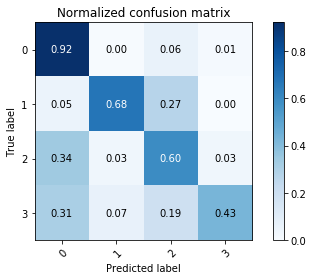

In [41]:
for n_esti in [200]:
    print("n_estimators = {}".format(n_esti))
    classifier = XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=n_esti, verbosity=1,
                                        objective='multi:softmax', booster='gbtree', tree_method='auto',
                                        n_jobs=-1, gpu_id=0, gamma=0, min_child_weight=3,
                                        max_delta_step=0, subsample=1, colsample_bytree=1,
                                        colsample_bylevel=1, colsample_bynode=1, reg_alpha=0,
                                        reg_lambda=1, scale_pos_weight=1, base_score=0.5,
                                        random_state=0, missing=None)
    
#     classifier1 = XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=180, verbosity=1,
#                                         objective='multi:softmax', booster='gbtree', tree_method='auto',
#                                         n_jobs=-1, gpu_id=0, gamma=0, min_child_weight=3,
#                                         max_delta_step=0, subsample=1, colsample_bytree=1,
#                                         colsample_bylevel=1, colsample_bynode=1, reg_alpha=0,
#                                         reg_lambda=1.5, scale_pos_weight=1, base_score=0.5,
#                                         random_state=1, missing=None)
#     classifier2 = XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=220, verbosity=1,
#                                         objective='multi:softmax', booster='gbtree', tree_method='auto',
#                                         n_jobs=-1, gpu_id=0, gamma=0, min_child_weight=3,
#                                         max_delta_step=0, subsample=1, colsample_bytree=1,
#                                         colsample_bylevel=1, colsample_bynode=1, reg_alpha=0,
#                                         reg_lambda=1.1, scale_pos_weight=1, base_score=0.5,
#                                         random_state=2, missing=None)


    classifier.fit(x_train_sample0,y_train_sample0)
#     classifier1.fit(x_train_sample1,y_train_sample1)
#     classifier2.fit(x_train_sample2,y_train_sample2)
    
    y_val_pred = classifier.predict(x_val)
#     y_val_pred1 = classifier1.predict(x_val)
#     y_val_pred2 = classifier2.predict(x_val)
    
#     print("depth = {}".format(depth))
    F = f1_score(y_val, y_val_pred, average='micro')
    print("FINAL VALIDATION1 {}".format(F))
    
#     F1 = f1_score(y_val, y_val_pred1, average='micro')
#     print("FINAL VALIDATION {}".format(F1))
    
#     F2 = f1_score(y_val, y_val_pred2, average='micro')
#     print("FINAL VALIDATION {}".format(F2))
    
    plot_conf(y_val, y_val_pred)
    

In [42]:
x_train_sample0.shape

(4227, 863)

FINAL VALIDATION1 0.53515625
Normalized confusion matrix
[[0.84 0.02 0.14 0.01]
 [0.87 0.01 0.12 0.  ]
 [0.83 0.03 0.13 0.  ]
 [0.9  0.   0.1  0.  ]]


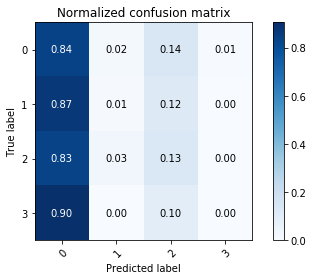

In [72]:
y_val_pred = classifier.predict(x_val)
y_val_pred1 = classifier1.predict(x_val)
y_val_pred2 = classifier2.predict(x_val)
y_val_pred_temp = np.vstack((np.vstack((y_val_pred,y_val_pred1)), y_val_pred2))

y_pred_temp = y_val_pred_temp.reshape((1280,3))


from scipy.stats import mode
y_val_pred_final = mode(y_pred_temp, axis=1)[0]

F_sum = f1_score(y_val, y_val_pred_final, average='micro')
print("FINAL VALIDATION1 {}".format(F_sum))

plot_conf(y_val, y_val_pred_final)

In [70]:
y_pred_temp[:10]

array([[0, 0, 0],
       [0, 2, 0],
       [0, 0, 2],
       [2, 0, 0],
       [0, 0, 2],
       [2, 0, 0],
       [0, 2, 2],
       [0, 0, 1],
       [1, 0, 1],
       [0, 0, 3]])

In [71]:
y_val_pred_final[:10]

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [2],
       [0],
       [1],
       [0]])

In [65]:
y_val_pred_final[:10]

array([[0],
       [0],
       [2],
       [0],
       [0],
       [0],
       [2],
       [0],
       [0],
       [0]])

In [98]:
y_pred_final.shape

(1280, 1)

In [32]:
F1 = f1_score(y_val, y_pred, average='micro')
print("FINAL VALIDATION {}".format(F1))

FINAL VALIDATION 0.78515625


In [60]:
print(grid.best_params_)

{'max_depth': 4, 'max_features': 500, 'n_estimators': 1000}


array([0, 0, 0, ..., 2, 0, 2])

In [28]:
def plot_conf(y_val, y_val_pred):
    from sklearn.metrics import confusion_matrix
    from sklearn.utils.multiclass import unique_labels

    class_names = np.array([0,1,2,3])
#     # Plot non-normalized confusion matrix
#     plot_confusion_matrix(y_val, y_val_pred, classes=class_names,
#                           title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plot_confusion_matrix(y_val, y_val_pred, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()

In [281]:
grid.cv_results_

{'mean_fit_time': array([290.71, 282.97, 259.19, 249.36, 241.66, 243.32, 247.85, 251.65,
        244.56, 246.53, 241.69, 242.46, 248.46, 252.  , 243.53, 247.65,
        240.45, 190.34]),
 'std_fit_time': array([ 1.61, 13.4 ,  1.89,  5.95,  2.87,  1.88,  2.96,  2.3 ,  2.34,
         1.9 ,  2.47,  1.51,  0.79,  2.98,  1.3 ,  1.37,  2.68, 60.07]),
 'mean_score_time': array([0.12, 0.09, 0.08, 0.08, 0.08, 0.14, 0.11, 0.08, 0.13, 0.08, 0.12,
        0.12, 0.08, 0.08, 0.11, 0.18, 0.13, 0.05]),
 'std_score_time': array([0.06, 0.01, 0.01, 0.  , 0.  , 0.07, 0.06, 0.  , 0.06, 0.  , 0.04,
        0.06, 0.01, 0.  , 0.07, 0.06, 0.07, 0.01]),
 'param_boost__max_depth': masked_array(data=[3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_boost__n_estimat

In [167]:
# [(0, 3030), (1, 443), (2, 1474), (3, 170)]
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE, SVMSMOTE, KMeansSMOTE, ADASYN
# rus = RandomUnderSampler(sampling_strategy={0:1100, 1:332, 2:1105, 3:128},random_state=0)
# rus1 = RandomUnderSampler(sampling_strategy={0:1100, 1:332, 2:1105, 3:128},random_state=1)
# rus2 = RandomUnderSampler(sampling_strategy={0:1100, 1:332, 2:1105, 3:128},random_state=2)
# ros = RandomOverSampler(random_state=42)
svmsmote = SVMSMOTE(sampling_strategy={0:3030, 1:443, 2:1474, 3:443},random_state = 42)
kmsmote = KMeansSMOTE(random_state = 42)
adasyn = ADASYN(random_state = 42)
# x_train_sample, y_train_sample = rus.fit_resample(x_train, y_train)
# x_train_sample, y_train_sample = svmsmote.fit_resample(x_train_sample, y_train_sample)

# x_train_sample1, y_train_sample1 = rus1.fit_resample(x_train, y_train)
# x_train_sample1, y_train_sample1 = svmsmote.fit_resample(x_train_sample1, y_train_sample1)

# x_train_sample2, y_train_sample2 = rus2.fit_resample(x_train, y_train)
X2_sample, labels_sample = svmsmote.fit_resample(X2,labels)
# x_train_sample, y_train_sample = ros.fit_resample(x_train,y_train)

# x_train_sample, y_train_sample = adasyn.fit_resample(x_train, y_train)

In [172]:
print(sorted(Counter(labels_sample).items()))

[(0, 3030), (1, 443), (2, 1474), (3, 443)]


In [175]:
# grid.fit(X2_sample, labels_sample)
# y_final = grid.predict(X_test)

classifier.fit(X2_sample, labels_sample)
y_final = classifier.predict(X_test)

sample = pd.read_csv("sample.csv", delimiter=',')
sample['y'] = y_final
sample.to_csv("y_pred_xgboost_featureextended.csv", index = False)

In [ ]:
y_all_pred = classifier.predict(X2)
F1 = f1_score(labels, y_all_pred, average='micro')
print("FINAL VALIDATION {}".format(F1))


from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
# y_val_pred = np.argmax(grid.predict(x_val), axis = 1)
# y_train_pred = np.argmax(grid.predict(x_train), axis = 1)



class_names = np.array([0,1,2,3])
# Plot non-normalized confusion matrix
# plot_confusion_matrix(labels, y_all_pred, classes=class_names,
#                       title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(labels, y_all_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')